## MPF training

Below is my test code to use MPF training for a fully-connected Boltzmann machine with 16 units with no GPU consideration.

In [5]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit

%matplotlib inline

In [6]:
def load_data(dataset = '32-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [7]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 16, temperature = 1,  W = None, b = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        if not b:
            initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
            b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
        self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W, self.b]
    
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns the cost of vanilla SGD. 
        The update rule enforces that the W matrix at each timestep is symmetric.
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
        cost = epsilon * T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + T.transpose(self.b)) / self.temperature)) 
        Wgrad = T.grad(cost, self.W)
        bgrad = T.grad(cost, self.b)
           
        Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)
        updates = [(self.W, Wupdate), (self.b, self.b - lr * bgrad )]

        return cost, updates

In [19]:
def trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    best_epoch = np.inf
    best_cost = np.inf
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = flow.b.get_value(borrow = True)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
        
        mseW = np.linalg.norm(W - W_learnt)/ (units**2 - units)/2
        mseb = np.linalg.norm(b - b_learnt)/ units
#         mse = (mseW * mseb)/(mseW + mseb)
        mse = mseW + mseb
        
        if mse < best_mse:
            best_mse = mse
            best_W[0] = flow.W.get_value(borrow = True)
            best_W[1] = mseW
            best_b[0] = flow.b.get_value(borrow = True)
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse, (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    
    fig, ax = plt.subplots(2, figsize=(20,10))
    fig.tight_layout()

    ax[0].plot(W.reshape(-1,1)[0:100], 'b')
    ax[0].plot(W_learnt.reshape(-1,1)[0:100], 'r')
    ax[0].plot(best_W[0].reshape(-1,1)[0:100], 'g')
    ax[0].set_title('W')
    ax[0].legend(['W', 'Learnt W', 'Best W'])
    ax[1].plot(b.reshape(-1,1), 'b')
    ax[1].plot(b_learnt.reshape(-1,1),'r')
    ax[1].plot(best_b[0].reshape(-1,1),'g')
    ax[1].set_title('b')
    ax[1].legend(['b', 'Learnt b', 'Best b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(best_mse))
    print ('Best W mse: {0}'.format(best_W[1]))
    print ('Best b mse: {0}'.format(best_b[1]))
    print ('Best epoch: {0}'.format(best_epoch))
    print ('=' * 51)

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.210865 mseW: 0.02295, mseb: 0.21111, mse: 0.23406 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.660363 mseW: 0.00498, mseb: 0.10507, mse: 0.11005 Time Elasped: 0.37 
Training epoch 200/1000, Cost: 0.659638 mseW: 0.00289, mseb: 0.07108, mse: 0.07397 Time Elasped: 0.70 
Training epoch 300/1000, Cost: 0.659498 mseW: 0.00226, mseb: 0.05336, mse: 0.05562 Time Elasped: 1.03 
Training epoch 400/1000, Cost: 0.659454 mseW: 0.00206, mseb: 0.04347, mse: 0.04552 Time Elasped: 1.34 
Training epoch 500/1000, Cost: 0.659436 mseW: 0.00200, mseb: 0.03785, mse: 0.03985 Time Elasped: 1.66 
Training epoch 600/1000, Cost: 0.659428 mseW: 0.00199, mseb: 0.03468, mse: 0.03667 Time Elasped: 1.97 
Training epoch 700/1000, Cost: 0.659424 mseW: 0.00199, mseb: 0.03292, mse: 0.03491 Time Elasped: 2.28 
Training epoch 800/1000, Cost: 0.659422 mse

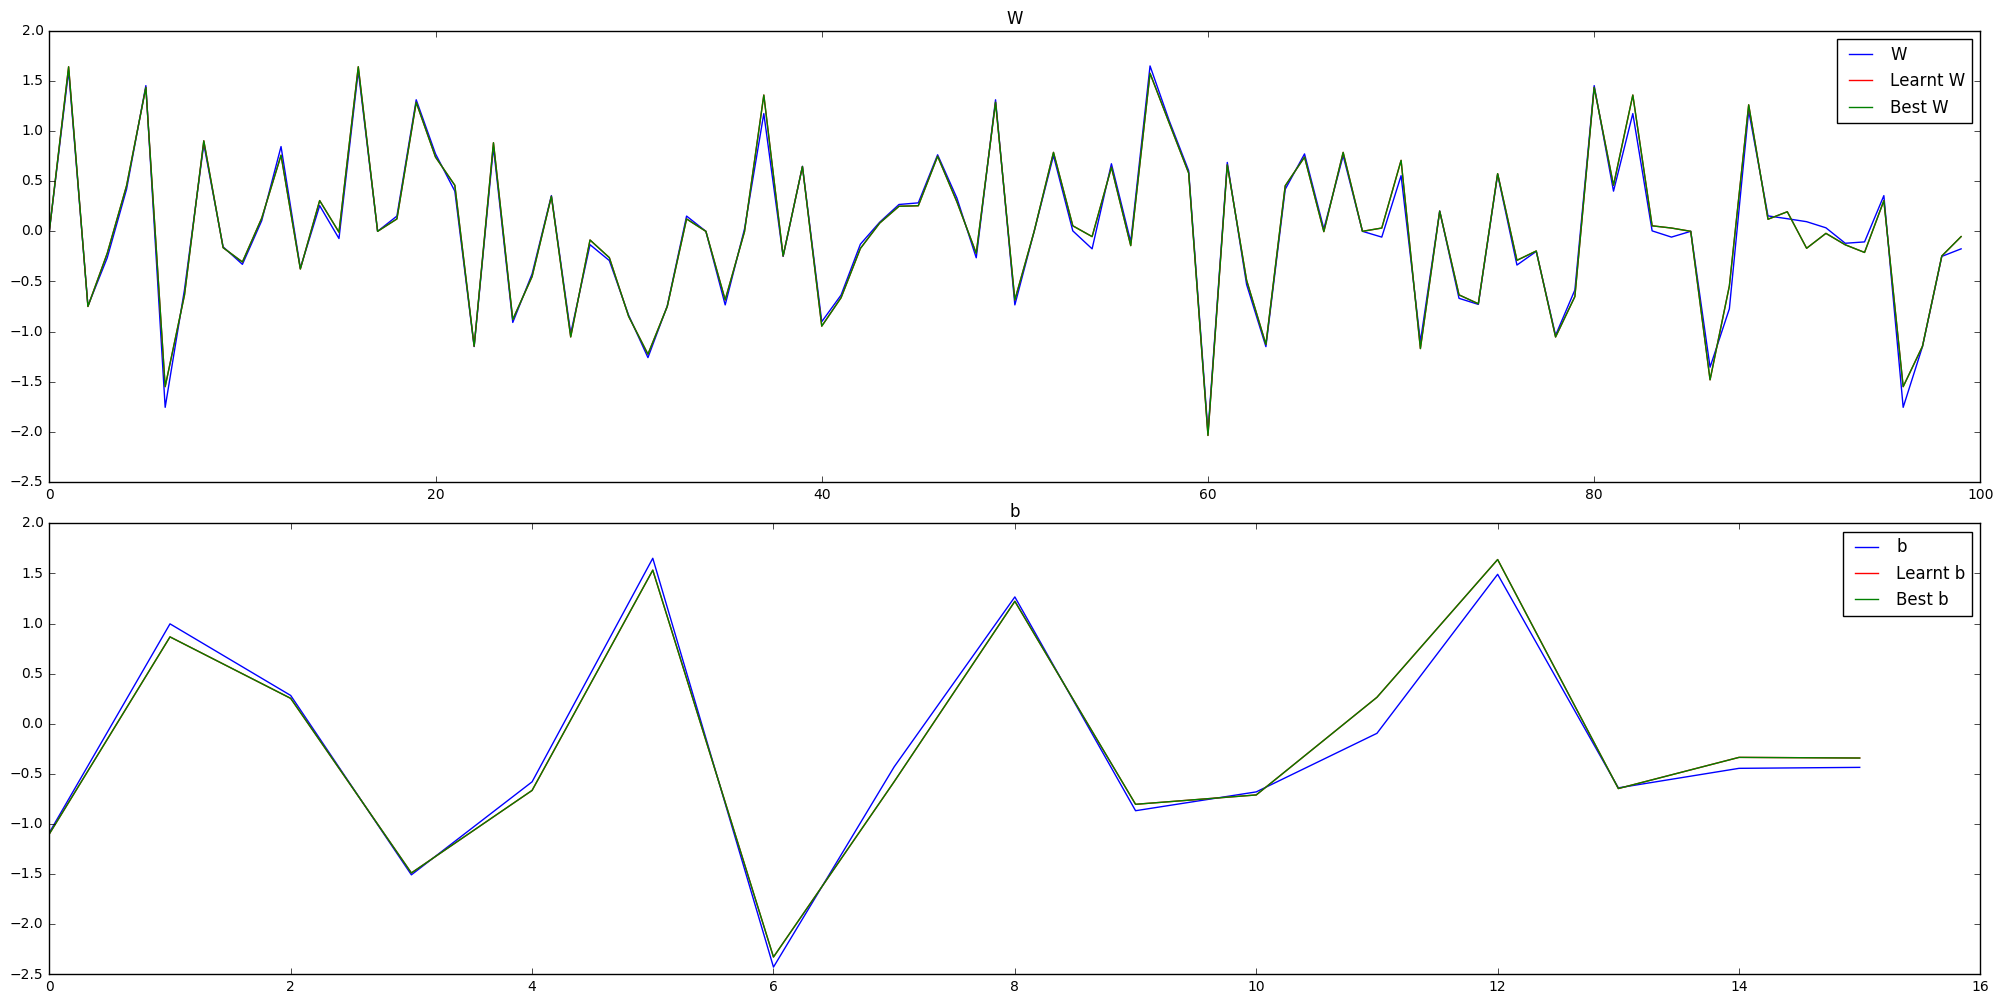

In [15]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.001
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 3.137507 mseW: 0.02658, mseb: 0.29045, mse: 0.31703 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.688426 mseW: 0.01666, mseb: 0.18185, mse: 0.19851 Time Elasped: 0.33 
Training epoch 200/1000, Cost: 0.672807 mseW: 0.01310, mseb: 0.17142, mse: 0.18452 Time Elasped: 0.64 
Training epoch 300/1000, Cost: 0.667029 mseW: 0.01091, mseb: 0.16205, mse: 0.17296 Time Elasped: 0.95 
Training epoch 400/1000, Cost: 0.664310 mseW: 0.00939, mseb: 0.15344, mse: 0.16283 Time Elasped: 1.25 
Training epoch 500/1000, Cost: 0.662821 mseW: 0.00826, mseb: 0.14556, mse: 0.15382 Time Elasped: 1.56 
Training epoch 600/1000, Cost: 0.661919 mseW: 0.00738, mseb: 0.13835, mse: 0.14573 Time Elasped: 1.87 
Training epoch 700/1000, Cost: 0.661329 mseW: 0.00667, mseb: 0.13175, mse: 0.13842 Time Elasped: 2.17 
Training epoch 800/1000, Cost: 0.660921 ms

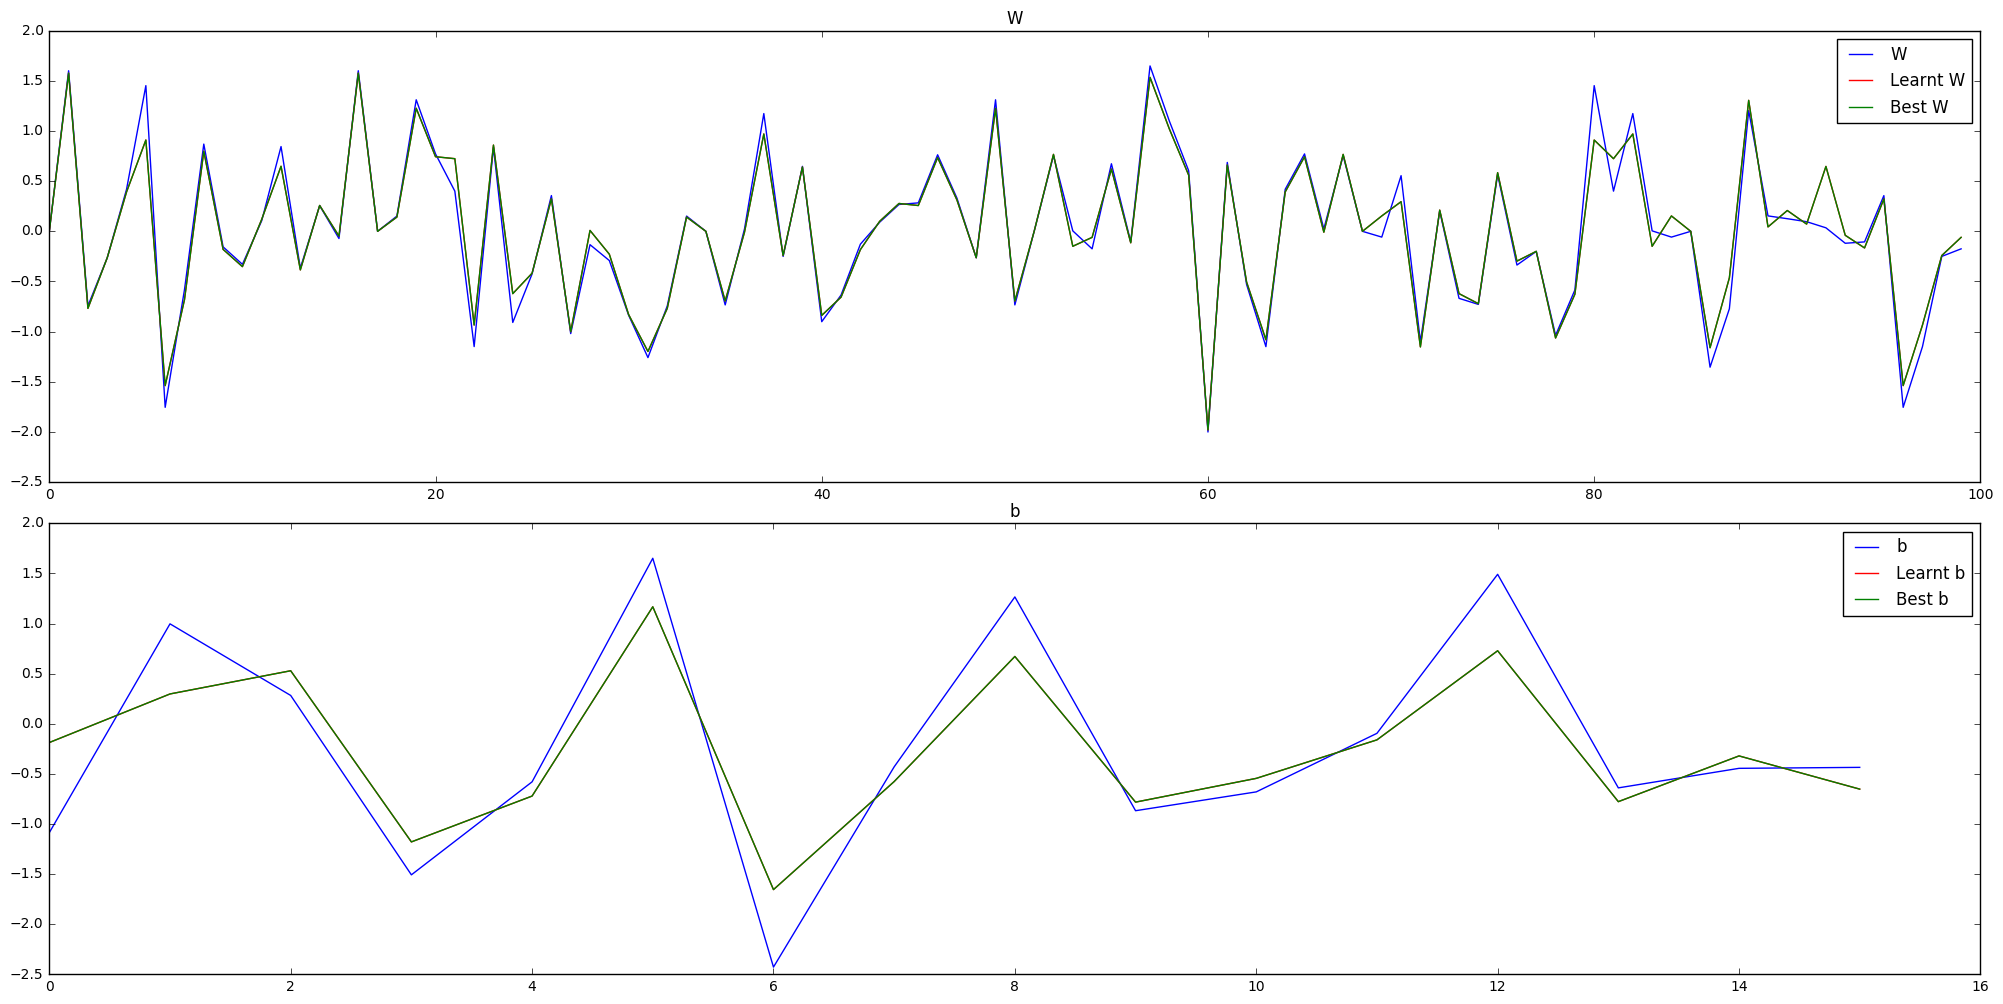

In [16]:
trainmpf(units = 16, lr = 1e-3, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.149929 mseW: 0.02308, mseb: 0.16737, mse: 0.19045 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.660273 mseW: 0.00510, mseb: 0.08290, mse: 0.08800 Time Elasped: 0.30 
Training epoch 200/1000, Cost: 0.659599 mseW: 0.00290, mseb: 0.05823, mse: 0.06113 Time Elasped: 0.61 
Training epoch 300/1000, Cost: 0.659479 mseW: 0.00222, mseb: 0.04505, mse: 0.04727 Time Elasped: 0.91 
Training epoch 400/1000, Cost: 0.659444 mseW: 0.00201, mseb: 0.03804, mse: 0.04005 Time Elasped: 1.21 
Training epoch 500/1000, Cost: 0.659430 mseW: 0.00196, mseb: 0.03436, mse: 0.03632 Time Elasped: 1.52 
Training epoch 600/1000, Cost: 0.659425 mseW: 0.00195, mseb: 0.03246, mse: 0.03441 Time Elasped: 1.82 
Training epoch 700/1000, Cost: 0.659422 mseW: 0.00196, mseb: 0.03151, mse: 0.03347 Time Elasped: 2.12 
Training epoch 800/1000, Cost: 0.659421 mse

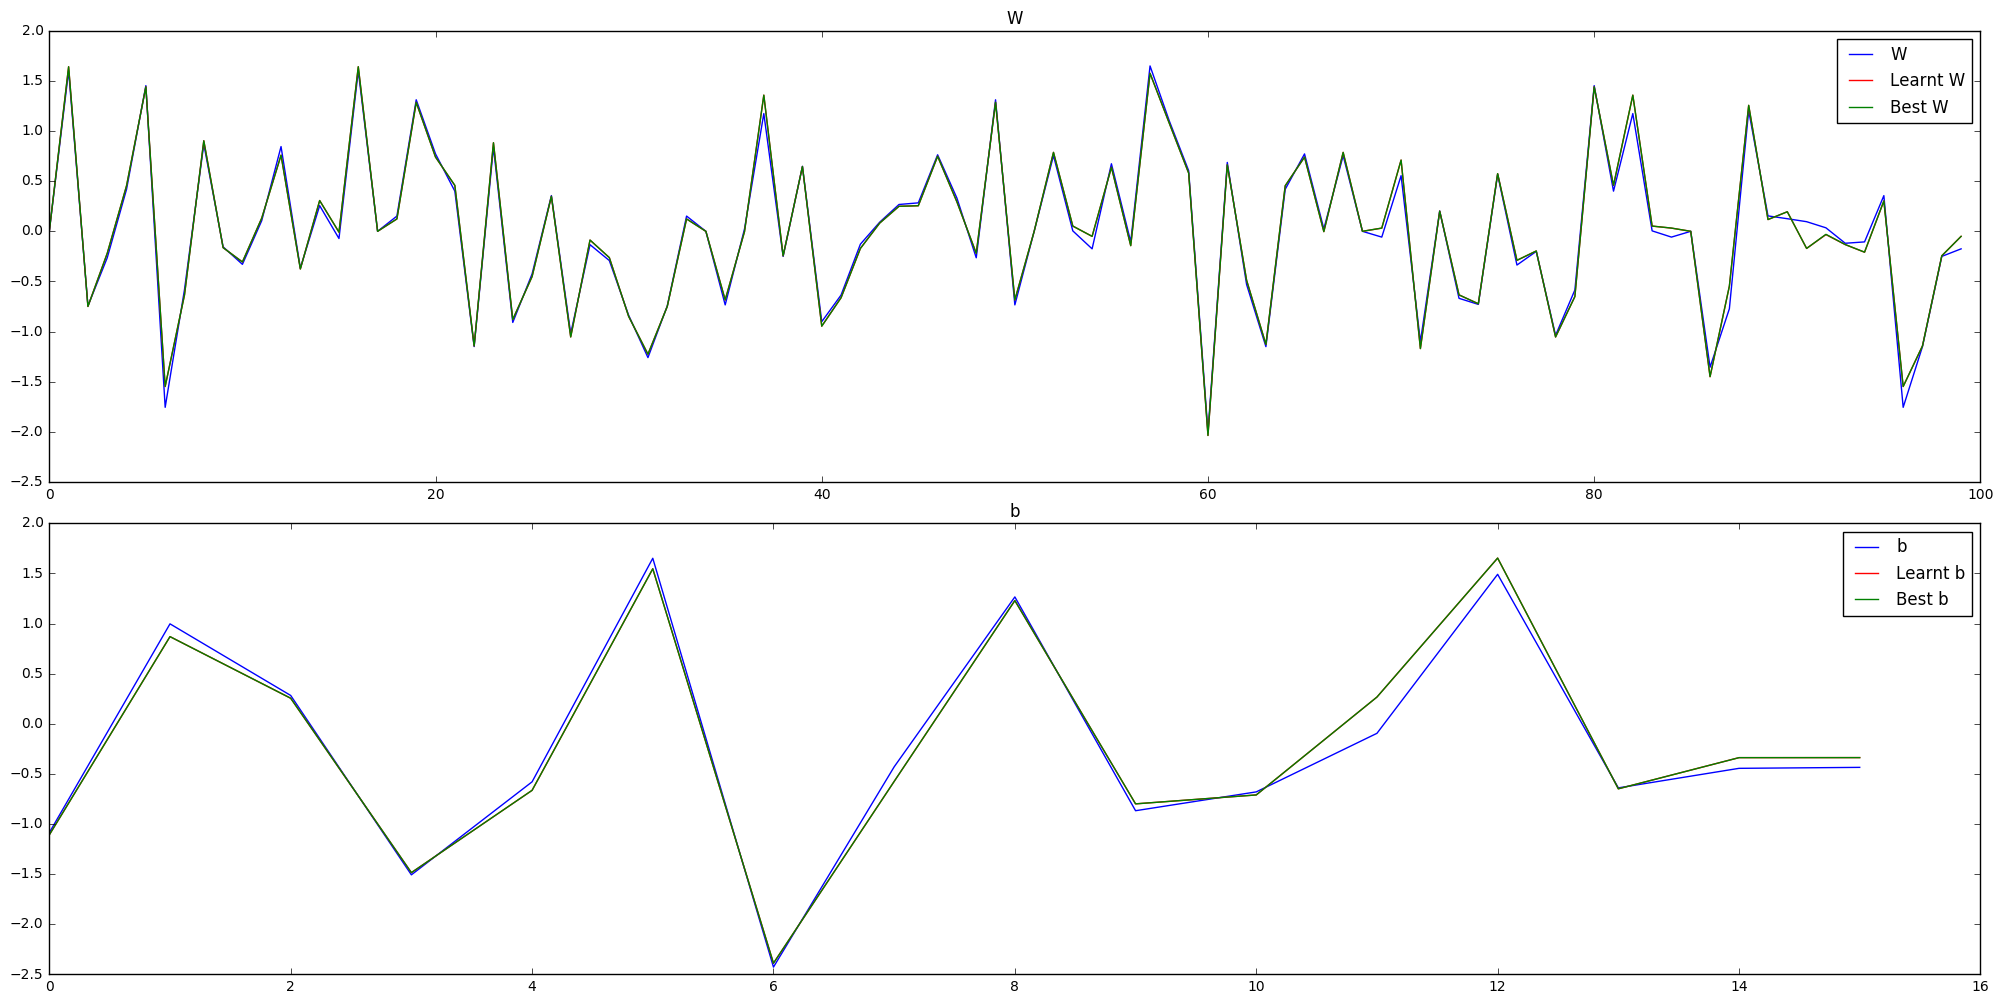

In [17]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.180043 mseW: 0.02189, mseb: 0.20330, mse: 0.22518 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.660342 mseW: 0.00499, mseb: 0.10279, mse: 0.10779 Time Elasped: 0.31 
Training epoch 200/1000, Cost: 0.659628 mseW: 0.00292, mseb: 0.06711, mse: 0.07003 Time Elasped: 0.61 
Training epoch 300/1000, Cost: 0.659492 mseW: 0.00228, mseb: 0.04927, mse: 0.05155 Time Elasped: 0.92 
Training epoch 400/1000, Cost: 0.659449 mseW: 0.00207, mseb: 0.04003, mse: 0.04210 Time Elasped: 1.22 
Training epoch 500/1000, Cost: 0.659433 mseW: 0.00201, mseb: 0.03535, mse: 0.03736 Time Elasped: 1.53 
Training epoch 600/1000, Cost: 0.659426 mseW: 0.00200, mseb: 0.03307, mse: 0.03506 Time Elasped: 1.83 
Training epoch 700/1000, Cost: 0.659423 mseW: 0.00200, mseb: 0.03200, mse: 0.03399 Time Elasped: 2.14 
Training epoch 800/1000, Cost: 0.659421 mse

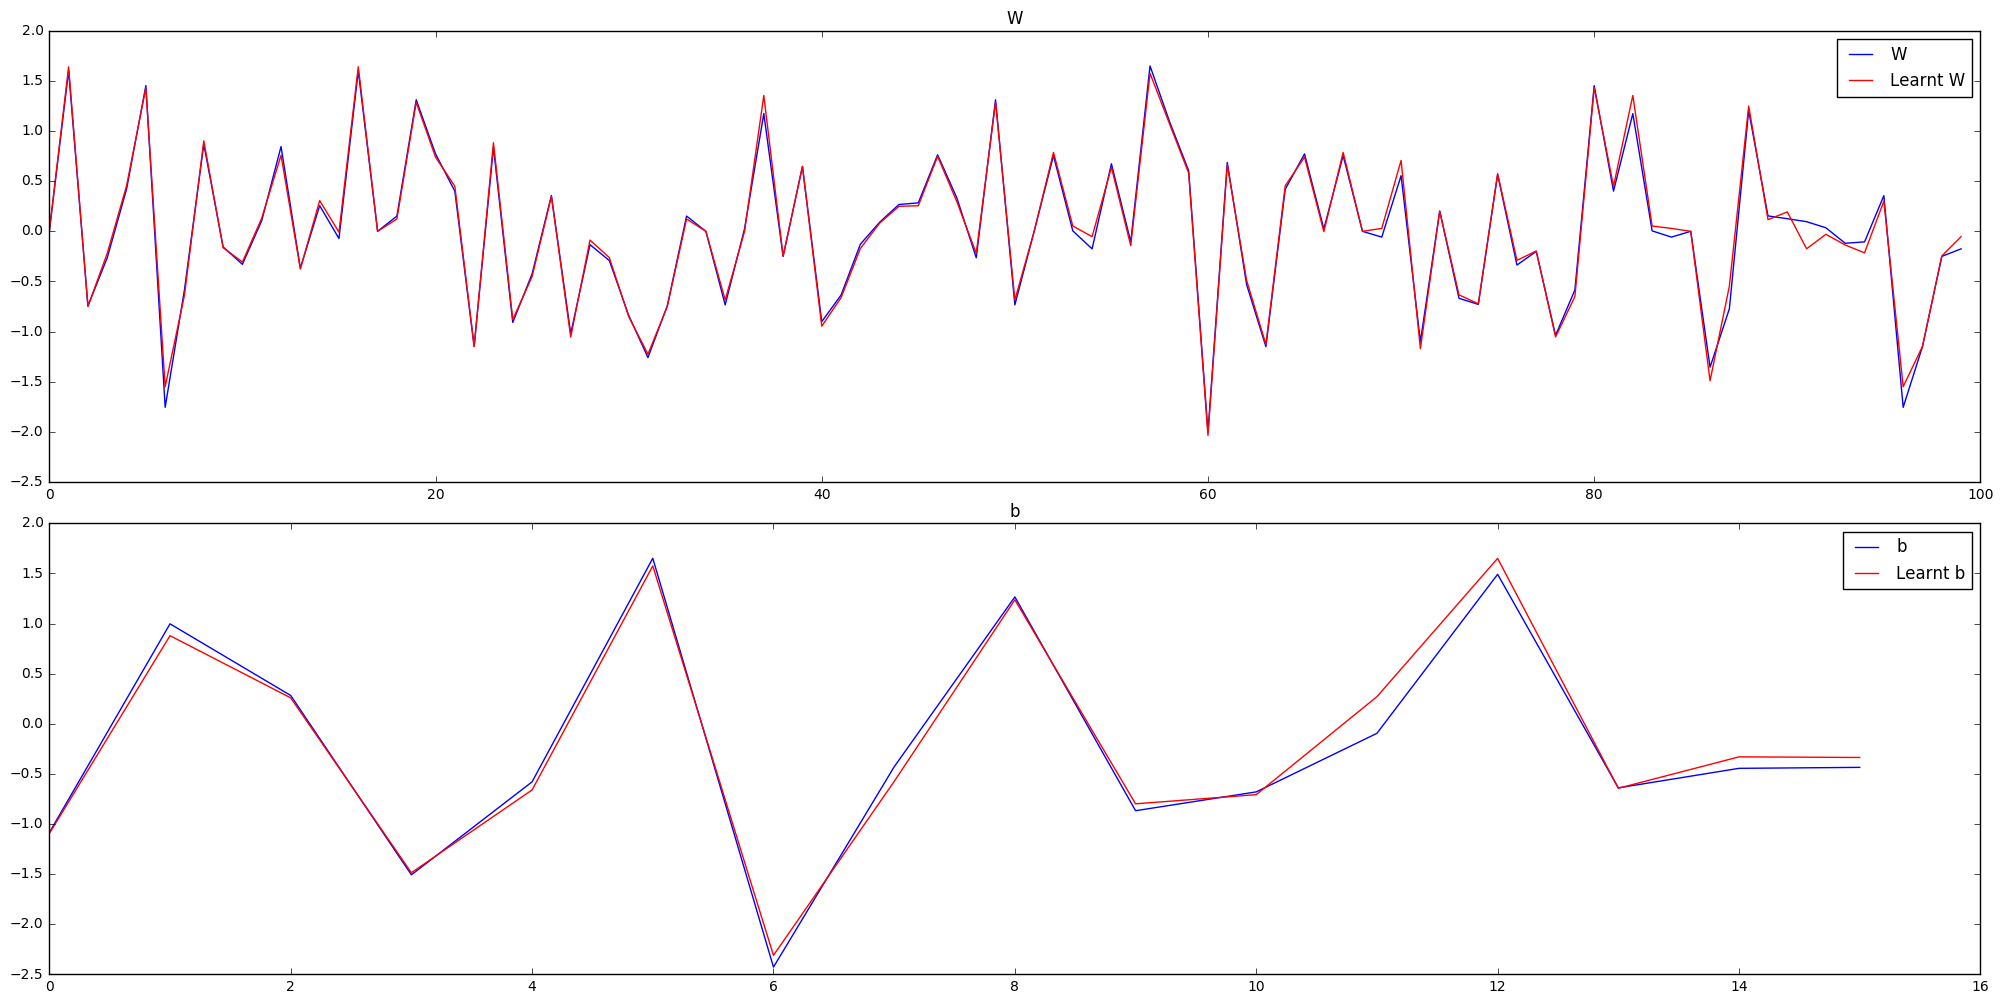

In [20]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')